In [1]:
import serial
import sys
from pydub import AudioSegment
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('Qt5Agg')

In [2]:
# Configuration
PORT = '/dev/ttyACM0'
BAUD_RATE = 115200
print("ok")

ok


In [3]:
SIGNAL_MEAN = 2080
SIGNAL_RANGE = 500
SIGNAL_RANGE_INV = 1/SIGNAL_RANGE

In [4]:
def normalize(raw):
    normalized = (raw - SIGNAL_MEAN) * SIGNAL_RANGE_INV
    normalized = 1.0 if normalized > 1.0 else normalized
    normalized = -1.0 if normalized < -1.0 else normalized
    return normalized

In [6]:
n = 31

# **Record 1 second**

In [11]:
with serial.Serial(PORT, BAUD_RATE, timeout=None) as ser:
    print("Waiting to receive samples...")

    samples = []
    count = 0
    num_samples = 16000
    num_seconds = 1

    for i in range(num_seconds * num_samples):
        line = ser.readline().strip()
        if not line:
            print("Warning: Received empty line, skipping.")
            continue
        
        try:
            sample_value = float(line)
            samples.append(sample_value)

            count += 1
                
        except ValueError:
            print(f"Warning: Could not parse line '{line}' as an float.")
            continue
    

    if len(samples) > num_seconds * num_samples:
        # Remove excess samples
        samples = samples[:num_seconds * num_samples]
    elif len(samples) < num_seconds * num_samples:
        # Pad with zeros
        samples = samples + [0] * (num_seconds * num_samples - len(samples))

    samples = list(map(normalize, samples))
    samples = np.array(samples, dtype=np.float32)
    samples = (samples * 32767).astype(np.int16)
    raw_data = samples.tobytes()


    
    audio_segment = AudioSegment(
        data=raw_data,
        sample_width=2,
        frame_rate=16000,
        channels=1
    )

    n = n+1
    file = str(n) + ".mp3"
    audio_segment.export(file, format="mp3")
    print("Recorded " + file)
    print(len(samples))

Waiting to receive samples...
Recorded 36.mp3
16000


In [47]:
len(samples)

15999

In [18]:
file = str(n) + ".mp3"
print(file)

0.mp3


# **Record 5 seconds**

In [16]:
with serial.Serial(PORT, BAUD_RATE, timeout=None) as ser:
    print("Waiting to receive samples...")

    samples = []
    count = 0

    # Read NUM_SAMPLES lines
    for i in range(NUM_SAMPLES):
        line = ser.readline().strip()
        if not line:
            print("Warning: Received empty line, skipping.")
            continue
        
        try:
            sample_value = float(line)
            samples.append(sample_value)

            count += 1
            if count % 10000 == 0:
                print(f"Received {count} samples...")
                
        except ValueError:
            print(f"Warning: Could not parse line '{line}' as an float.")
            continue
        


    if len(samples) < NUM_SAMPLES:
        print(f"Warning: Expected {NUM_SAMPLES} samples, but received {len(samples)}.")
    else:
        print("All samples successfully received and stored in memory.")

    print("First 10 samples:", samples[:10])

Waiting to receive samples...
All samples successfully received and stored in memory.
First 10 samples: [0.08, 0.08, 0.08, 0.0801, 0.0801, 0.0802, 0.0803, 0.0804, 0.0806, 0.0807]


In [17]:
len(samples)

1024

In [58]:
normalized_samples = list(map(normalize, samples))

In [37]:
print("First 10 normalized samples:", normalized_samples[:10])

First 10 normalized samples: [0.020833333333333336, 0.015000000000000001, 0.030000000000000002, 0.02666666666666667, 0.011666666666666667, 0.020833333333333336, 0.0, 0.007500000000000001, 0.023333333333333334, -0.0016666666666666668]


In [18]:
def plot_array(y, sr):
    time = np.linspace(0, len(y) / sr, len(y))

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, y, label="Amplitude")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.grid()
    plt.tight_layout()
    plt.show()

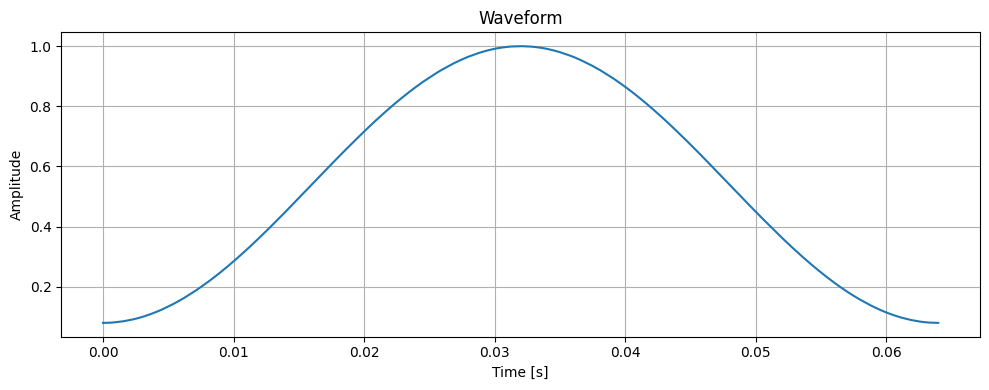

In [19]:
plot_array(samples, 16000)

In [60]:
normalized_samples = np.array(normalized_samples, dtype=np.float32)

int_samples = (normalized_samples * 32767).astype(np.int16)
raw_data = int_samples.tobytes()

# Create an AudioSegment. 
# - sample_width=2 for 16-bit audio
# - frame_rate=16000 as given
# - channels=1 (mono)
audio_segment = AudioSegment(
    data=raw_data,
    sample_width=2,
    frame_rate=16000,
    channels=1
)

In [63]:
from pydub.playback import play

play(audio_segment)

### EXPORT

In [64]:
audio_segment.export("1-2050-550.mp3", format="mp3")

<_io.BufferedRandom name='1-2050-550.mp3'>

### MFCC

In [ ]:
def audio_to_mfcc(audio_samples, sample_rate=16000,
                  n_mfcc=13, n_fft=512, win_length=400, hop_length=160,
                  fmin=20, fmax=None):
    # Convert int16 samples to floating point and normalize to [-1, 1]
    audio_float = audio_samples.astype(np.float32) / 32768.0
    
    # Compute MFCCs using librosa
    
    # Normalize MFCCs (mean normalization)
    mfcc_features -= (np.mean(mfcc_features, axis=1, keepdims=True) + 1e-8)
    
    return mfcc_features

In [57]:
from librosa.feature import mfcc

mfcc_features = mfcc(y=normalized_samples, sr=16000, n_mfcc=13, n_fft=512, hop_length=160, win_length=400, fmin=20, fmax=None)
mfcc_features -= (np.mean(mfcc_features, axis=0) + 1e-8)
